In [1]:
! nvidia-smi

Mon Jun 21 05:38:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction
In this kernel we will attempt to reproduce a minimal version of [Instance-aware Image Colorization](https://arxiv.org/abs/2005.10825) by Jheng-Wei Su et. al. The authors suggest a three way architecture for colorization.

- Full image colorization
- Instance colorization
- Fusion module

This is a minimal implementation of the paper where I have made some essential changes:
- Using RGB color space instead of L\*a\*b\* color space.
- Using the bbox provided by the dataset used, instead of using a pretrained Object Detector model to derive the bbox (this step takes a lot of time to implement).
- Changing the U-Net architecture and training it E2E instead of using a pretrained model and then using transfer learning.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

from tqdm.notebook import tqdm

We are going to use the PASCAL VOC dataset. The idea here is to keep an original dataset at hand and change the dataset as we move along the procedures.

In [3]:
ori_train_ds = tfds.load('voc', split='train')
ori_test_ds = tfds.load('voc', split='validation')

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVXG3CN/voc-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVXG3CN/voc-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteVXG3CN/voc-validation.tfrecord
Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


## First Stage
In the first stage we go for the total image colorization. We build a U-Net and try colorizing the entire image at a go. 

The loss proposed by the authors is similar to the one used by Zhang et. al. (Real- time user-guided image colorization with learned deep priors).
$$
l_{\delta}(x,y)=\frac{1}{2}(x-y)^2\mathbb{1}_{\{|x-y|<\delta\}}+\delta(|x-y|-\frac{1}{2}\delta)\mathbb{1}_{\{|x-y|\geqslant{\delta}\}}
$$

The loss function $l_\delta$ is evaluated at each pixel and summed together to evaluate the loss $\mathcal{L}$ for a whole image.
$$
\mathcal{L}=\sum_{h,w}\sum_{q}(l_{\delta})
$$


### Dataset
At each stage we need to mould the original dataset a bit. Here we will preprocess the image. The preprocessing stage consists of:
- Resizing the images to 256,256
- Converting the dtype from uint8 to float32
- Scaling the images to 0 to 1

In [4]:
def preprocess_one(element):
    image = element['image']
    image = tf.image.resize(image, (256,256))
    color = tf.cast(image, tf.float32)/255.0
    gray = tf.image.rgb_to_grayscale(color)
    return gray, color

In [5]:
one_train_ds = ori_train_ds.map(preprocess_one).batch(32)

gray, color = next(iter(one_train_ds))
print(gray.shape)
print(color.shape)

(32, 256, 256, 1)
(32, 256, 256, 3)


In [6]:
print("Gray")
print(f"  [SHAPE]: {gray.shape}")
print(f"  [MIN]:{tf.math.reduce_min(gray)}")
print(f"  [MEAN]:{tf.math.reduce_mean(gray)}")
print(f"  [MAX]:{tf.math.reduce_max(gray)}")


print("Color")
print(f"  [SHAPE]: {color.shape}")
print(f"  [MIN]:{tf.math.reduce_min(color)}")
print(f"  [MEAN]:{tf.math.reduce_mean(color)}")
print(f"  [MAX]:{tf.math.reduce_max(color)}")

Gray
  [SHAPE]: (32, 256, 256, 1)
  [MIN]:0.0
  [MEAN]:0.42513731122016907
  [MAX]:0.9999000430107117
Color
  [SHAPE]: (32, 256, 256, 3)
  [MIN]:0.0
  [MEAN]:0.4175087511539459
  [MAX]:1.0


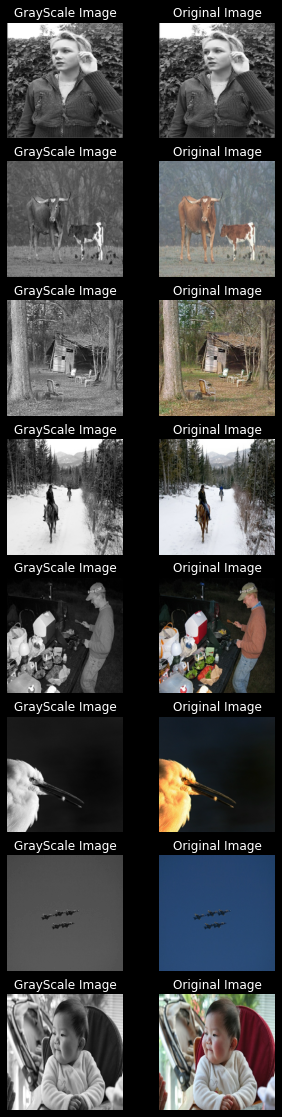

In [7]:
idx = np.random.choice(len(gray)-8)
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 20))
[ax.axis("off") for ax in np.ravel(axes)]


for (ax_bw, ax_orig), gray_im, color_im in zip(axes, gray[idx:idx+8], color[idx:idx+8]):
    ax_bw.imshow(gray_im[...,0], cmap="gray")
    ax_bw.set_title("GrayScale Image")
    
    ax_orig.imshow(color_im)
    ax_orig.set_title("Original Image")

### U-Net
We will be using a U-Net architecture for colorization. It has been seen that architectures of this sort helps in synthesis of images.

In [8]:
def downsample(input_shape, filter, i):
    # input_shape = (H,W,C)
    model = tf.keras.Sequential(name=f"downsample_{i}")
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=filter,
        kernel_size=3,
        strides=2,
        padding='same',
        activation='relu'))

    return model

In [9]:
def upsample(input_shape, filter, i):
    # input_shape = (H,W,C)
    model = tf.keras.Sequential(name=f"upsample_{i}")
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2D(
        filters=input_shape[-1],
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=filter,
        kernel_size=3,
        strides=2,
        padding='same',
        activation='relu'))

    return model

In [10]:
def get_unet(input_name, model_name):
    inputs = tf.keras.Input((256,256,1), name=input_name)
    
    down_1 = downsample((256,256,1), 64, 1)
    down_2 = downsample((128,128,64), 128, 2)
    down_3 = downsample((64,64,128), 256, 3)
    down_4 = downsample((32,32,256), 512, 4)

    up_1 = upsample((16,16,512), 256, 1)
    up_2 = upsample((32,32,256), 128, 2)
    up_3 = upsample((64,64,128), 64, 3)
    up_4 = upsample((128,128,64), 3, 4)

    x1 = down_1(inputs) # 128,128,64
    x2 = down_2(x1)     # 64,64,128
    x3 = down_3(x2)     # 32,32,256
    x4 = down_4(x3)     # 16,16,512

    x5 = up_1(x4)       # 32,32,256
    x5 = tf.keras.layers.Add()([x5, x3])
    x6 = up_2(x5)       # 64,64,128
    x6 = tf.keras.layers.Add()([x6, x2])
    x7 = up_3(x6)       # 128,128,64
    x7 = tf.keras.layers.Add()([x7, x1])
    x8 = up_4(x7)       # 256,256,3


    color = tf.keras.layers.Conv2D(
        filters=3,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='sigmoid', name="last_conv")(x8)

    model = tf.keras.Model(inputs, color, name=model_name)
    return model

In [11]:
# The total colorizer
unet_total = get_unet("input_total", "unet_total")
# The instance colorizer
unet_instance = get_unet("input_instance", "unet_instance")

In [12]:
def loss_function(true_tensor, pred_tensor):
    absolute_error = tf.math.abs(true_tensor - pred_tensor)
    sq_error = tf.math.multiply(absolute_error, absolute_error)
    first_half = 0.5 * tf.where((absolute_error < 1.0), sq_error, tf.zeros_like(sq_error))
    place_holder = absolute_error - 0.5
    second_half = tf.where((absolute_error >= 1.0), place_holder, tf.zeros_like(place_holder))

    total = first_half + second_half
    return tf.math.reduce_mean(total)

In [13]:
unet_total.compile(optimizer='adam', loss=loss_function)
history_total = unet_total.fit(one_train_ds, epochs=100)

unet_total.save_weights('total')

Epoch 1/100
79/79 [==============================] - 46s 338ms/step - loss: 0.0374
Epoch 2/100
79/79 [==============================] - 26s 330ms/step - loss: 0.0176
Epoch 3/100
79/79 [==============================] - 26s 330ms/step - loss: 0.0114
Epoch 4/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0088
Epoch 5/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0078
Epoch 6/100
79/79 [==============================] - 26s 330ms/step - loss: 0.0071
Epoch 7/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0067
Epoch 8/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0063
Epoch 9/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0060
Epoch 10/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0058
Epoch 11/100
79/79 [==============================] - 26s 329ms/step - loss: 0.0056
Epoch 12/100
79/79 [==============================] - 26s 330ms/step - loss: 0.0054
E

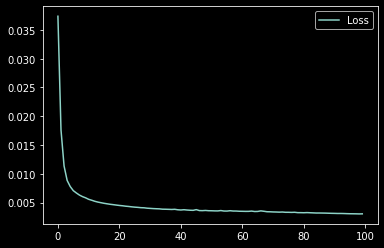

In [14]:
plt.plot(history_total.history["loss"], label="Loss")
plt.legend()
plt.show()

In [15]:
one_test_ds = ori_test_ds.map(preprocess_one).batch(32)

gray, _ = next(iter(one_test_ds))

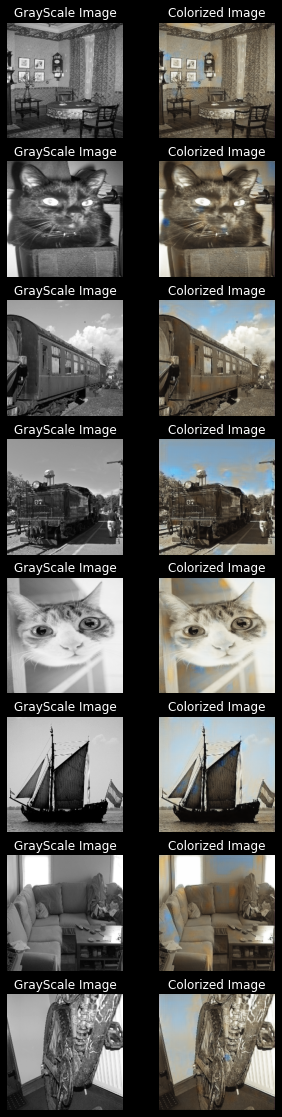

In [16]:
idx = np.random.choice(len(gray)-8)
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 20))
[ax.axis("off") for ax in np.ravel(axes)]


for (ax_bw, ax_orig), gray_im in zip(axes, gray[idx:idx+8]):
    ax_bw.imshow(gray_im[...,0], cmap="gray")
    ax_bw.set_title("GrayScale Image")
    
    pred = unet_total.predict(gray_im[None, ...])
    ax_orig.imshow(pred[0])
    ax_orig.set_title("Colorized Image")

## Second Stage
In the second stage we will be working with the instances. The same architecture will be use to fine tune on the instances but we will need to change the dataset that we use in this stage.

The dataset:
- Needs to have instances from the total image -- We will be doing one instance for the time being
- The architecture is the same
- Loss is the same

In [17]:
def preprocess_two(element):
    image = element['image']
    boxes = element['objects']['bbox']
    index = tf.random.uniform((1,), 0, len(boxes), dtype=tf.int32)[0]
    box = boxes[index]

    image = tf.image.resize(image, (256,256))
    color = tf.cast(image, tf.float32)/255.0
    
    ymin = tf.cast(tf.math.round(box[0] * 256), dtype=tf.int32)
    xmin = tf.cast(tf.math.round(box[1] * 256), dtype=tf.int32)
    ymax = tf.cast(tf.math.round(box[2] * 256), dtype=tf.int32)
    xmax = tf.cast(tf.math.round(box[3] * 256), dtype=tf.int32)

    color = tf.image.crop_to_bounding_box(
        color,
        ymin,
        xmin,
        ymax - ymin,
        xmax - xmin)

    color = tf.image.resize(color, (256,256))
    gray = tf.image.rgb_to_grayscale(color)
    return gray, color

In [18]:
two_train_ds = ori_train_ds.map(preprocess_two).batch(32)

gray, color = next(iter(two_train_ds))
print(gray.shape)
print(color.shape)

(32, 256, 256, 1)
(32, 256, 256, 3)


In [19]:
print("Gray")
print(f"  [SHAPE]: {gray.shape}")
print(f"  [MIN]:{tf.math.reduce_min(gray)}")
print(f"  [MEAN]:{tf.math.reduce_mean(gray)}")
print(f"  [MAX]:{tf.math.reduce_max(gray)}")


print("Color")
print(f"  [SHAPE]: {color.shape}")
print(f"  [MIN]:{tf.math.reduce_min(color)}")
print(f"  [MEAN]:{tf.math.reduce_mean(color)}")
print(f"  [MAX]:{tf.math.reduce_max(color)}")

Gray
  [SHAPE]: (32, 256, 256, 1)
  [MIN]:0.0
  [MEAN]:0.38683080673217773
  [MAX]:0.9999000430107117
Color
  [SHAPE]: (32, 256, 256, 3)
  [MIN]:0.0
  [MEAN]:0.3809337615966797
  [MAX]:1.0


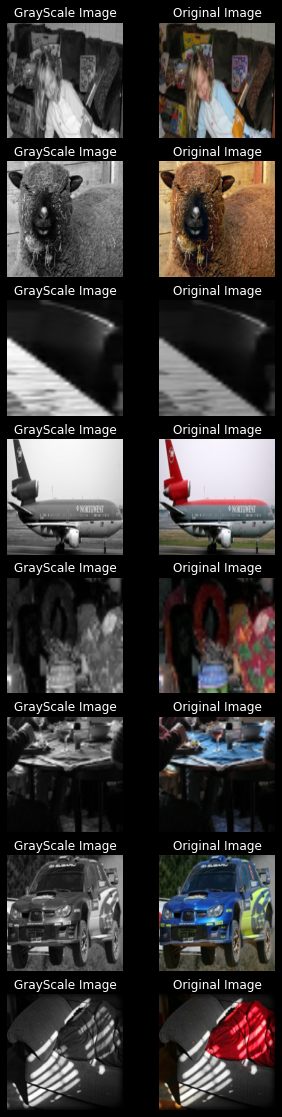

In [20]:
idx = np.random.choice(len(gray)-8)
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 20))
[ax.axis("off") for ax in np.ravel(axes)]


for (ax_bw, ax_orig), gray_im, color_im in zip(axes, gray[idx:idx+8], color[idx:idx+8]):
    ax_bw.imshow(gray_im[...,0], cmap="gray")
    ax_bw.set_title("GrayScale Image")
    
    ax_orig.imshow(color_im)
    ax_orig.set_title("Original Image")

In [21]:
# build a model and then take the weights of the previous model
unet_instance.load_weights('total')

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = loss_function

unet_instance.compile(optimizer=opt, loss=loss_fn)
history_instance = unet_instance.fit(two_train_ds, epochs=50)

Epoch 1/50
79/79 [==============================] - 28s 326ms/step - loss: 0.0030
Epoch 2/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0030
Epoch 3/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 4/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 5/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 6/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0030
Epoch 7/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0030
Epoch 8/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 9/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 10/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 11/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0030
Epoch 12/50
79/79 [==============================] - 26s 326ms/step - loss: 0.0029
Epoch 13/50
7

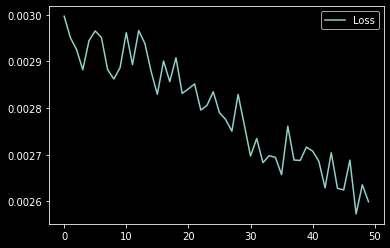

In [23]:
plt.plot(history_instance.history["loss"], label="Loss")
plt.legend()
plt.show()

In [24]:
two_test_ds = ori_test_ds.map(preprocess_two).batch(32)

gray, _ = next(iter(two_test_ds))

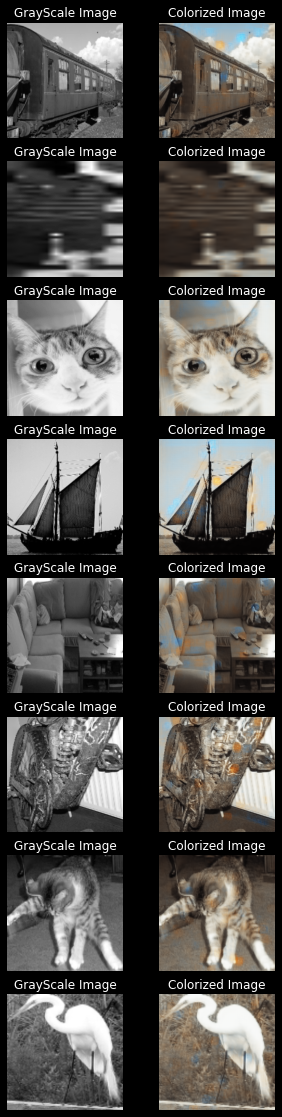

In [25]:
idx = np.random.choice(len(gray)-8)
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 20))
[ax.axis("off") for ax in np.ravel(axes)]


for (ax_bw, ax_orig), gray_im in zip(axes, gray[idx:idx+8]):
    ax_bw.imshow(gray_im[...,0], cmap="gray")
    ax_bw.set_title("GrayScale Image")
    
    pred = unet_instance.predict(gray_im[None, ...])
    ax_orig.imshow(pred[0])
    ax_orig.set_title("Colorized Image")

## Fusion Model

In [26]:
def preprocess_three(element):
    image = element['image']
    boxes = element['objects']['bbox']
    index = tf.random.uniform((1,), 0, len(boxes), dtype=tf.int32)[0]
    box = boxes[index]

    image = tf.image.resize(image, (256,256))
    ori_color = tf.cast(image, tf.float32)/255.0
    ori_gray = tf.image.rgb_to_grayscale(ori_color)
    
    ymin = tf.cast(tf.math.round(box[0] * 256), dtype=tf.int32)
    xmin = tf.cast(tf.math.round(box[1] * 256), dtype=tf.int32)
    ymax = tf.cast(tf.math.round(box[2] * 256), dtype=tf.int32)
    xmax = tf.cast(tf.math.round(box[3] * 256), dtype=tf.int32)

    crop_color = tf.image.crop_to_bounding_box(
        ori_color,
        ymin,
        xmin,
        ymax - ymin,
        xmax - xmin)

    crop_color = tf.image.resize(crop_color, (256,256))
    crop_gray = tf.image.rgb_to_grayscale(crop_color)
    return {"ori_gray": ori_gray, "crop_gray": crop_gray, "box": box}, ori_color

In [27]:
three_train_ds = ori_train_ds.map(preprocess_three).batch(1)

inputs, ori_color = next(iter(three_train_ds))
print(inputs["ori_gray"].shape)
print(inputs["crop_gray"].shape)
print(inputs["box"].shape)
print(ori_color.shape)

(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 4)
(1, 256, 256, 3)


In [35]:
# Save the blocks
layer_names = [
    "downsample_1",
    "downsample_2",
    "downsample_3",
    "downsample_4",
    "upsample_1",
    "upsample_2",
    "upsample_3",
    "upsample_4",
]

for name in layer_names:
    unet_total.get_layer(name).save_weights(f"total/{name}")
    unet_instance.get_layer(name).save_weights(f"instance/{name}")

In [36]:
def resize_pad(i, w_i, box, s_shape):
    # i.shape == H, W, C
    # w_i.shape == H, W, C
    # box.shape == 4,

    ymin = tf.cast(tf.math.round(box[0][0] * s_shape), dtype=tf.int32)
    xmin = tf.cast(tf.math.round(box[0][1] * s_shape), dtype=tf.int32)
    ymax = tf.cast(tf.math.round(box[0][2] * s_shape), dtype=tf.int32)
    xmax = tf.cast(tf.math.round(box[0][3] * s_shape), dtype=tf.int32)

    height = tf.maximum(tf.math.abs(ymax - ymin), 1)
    width =  tf.maximum(tf.math.abs(xmax - xmin), 1)

    ymin = tf.minimum(tf.math.abs(s_shape - height), ymin)
    xmin = tf.minimum(tf.math.abs(s_shape - width), xmin)

    i_resize = tf.image.resize(i, (height, width))
    i_pad = tf.image.pad_to_bounding_box(
        i_resize,
        ymin,
        xmin,
        s_shape,
        s_shape
    ) # 1, H, W, C


    wi_resize = tf.image.resize(w_i, (height, width))
    wi_pad = tf.image.pad_to_bounding_box(
        wi_resize,
        ymin,
        xmin,
        s_shape,
        s_shape
    ) # 1, H, W, C


    return i_pad, wi_pad

In [37]:
def fusion_block(t, i, channels, s_shape, box):
    # t.shape == H, W, C
    # i.shape == H, W, C

    conv_t = tf.keras.Sequential(
        [
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
        ]
    )

    conv_i = tf.keras.Sequential(
        [
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
         tf.keras.layers.Conv2D(channels, 3, padding='same', activation='relu'),
        ]
    )

    w_t = conv_t(t) # H, W, C
    w_i = conv_i(i) # H, W, C

    # Resize and Pad w_i and i
    i, w_i = resize_pad(i, w_i, box, s_shape)

    features = tf.stack([t, i], axis=0)
    weights = tf.stack([w_t, w_i], axis=0)
    soft_weights = tf.math.softmax(weights, axis=0)

    out = tf.math.multiply(features, soft_weights)
    out = tf.math.reduce_sum(out, axis=0)

    return out

In [45]:
def get_fusion_model():
    # Build the entire fusion model

    inputs_t = tf.keras.Input((256, 256, 1), name="ori_gray")    # 256, 256, 1
    inputs_i = tf.keras.Input((256, 256, 1), name="crop_gray")   # 256, 256, 1
    bbox = tf.keras.Input((4,), name="box")                      # 4,
    
    # downsample_1
    down_t1 = downsample((256,256,1), 64, 1)
    down_t1.load_weights('total/downsample_1')
    down_t1.trainable=False
    t1 = down_t1(inputs_t)
    down_i1 = downsample((256,256,1), 64, 2)
    down_i1.load_weights('instance/downsample_1')
    down_i1.trainable=False
    i1 = down_i1(inputs_i)
    f1 = fusion_block(t1, i1, 64, 128, bbox)

    # downsample_2
    down_t2 = downsample((128,128,64), 128, 3)
    down_t2.load_weights('total/downsample_2')
    down_t2.trainable=False
    t2 = down_t2(f1)
    down_i2 = downsample((128,128,64), 128, 4)
    down_i2.load_weights('instance/downsample_2')
    down_i2.trainable=False
    i2 = down_i2(i1)
    f2 = fusion_block(t2, i2, 128, 64, bbox)


    # downsample_3
    down_t3 = downsample((64,64,128), 256, 5)
    down_t3.load_weights('total/downsample_3')
    down_t3.trainable=False
    t3 = down_t3(f2)
    down_i3 = downsample((64,64,128), 256, 6)
    down_i3.load_weights('instance/downsample_3')
    down_i3.trainable=False
    i3 = down_i3(i2)
    f3 = fusion_block(t3, i3, 256, 32, bbox)
    

    # downsample_4
    down_t4 = downsample((32,32,256), 512, 7)
    down_t4.load_weights('total/downsample_4')
    down_t4.trainable=False
    t4 = down_t4(f3)
    down_i4 = downsample((32,32,256), 512, 8)
    down_i4.load_weights('instance/downsample_4')
    down_i4.trainable=False
    i4 = down_i4(i3)
    f4 = fusion_block(t4, i4, 512, 16, bbox)


    # upsample_1
    up_t1 = upsample((16,16,512), 256, 1)
    up_t1.load_weights('total/upsample_1')
    up_t1.trainable=False
    t5 = up_t1(f4)
    up_i1 = upsample((16,16,512), 256, 2)
    up_i1.load_weights('instance/upsample_1')
    up_i1.trainable=False
    i5 = up_i1(i4)
    f5 = fusion_block(t5, i5, 256, 32, bbox)
    f5 = tf.keras.layers.Add()([f5, f3])

    # upsample_2
    up_t2 = upsample((32,32,256), 128, 3)
    up_t2.load_weights('total/upsample_2')
    up_t2.trainable=False
    t6 = up_t2(f5)
    up_i2 = upsample((32,32,256), 128, 4)
    up_i2.load_weights('instance/upsample_2')
    up_i2.trainable=False
    i6 = up_i2(i5)
    f6 = fusion_block(t6, i6, 128, 64, bbox)
    f6 = tf.keras.layers.Add()([f6, f2])


    # upsample_3
    up_t3 = upsample((64,64,128), 64, 5)
    up_t3.load_weights('total/upsample_3')
    up_t3.trainable=False
    t7 = up_t3(f6)
    up_i3 = upsample((64,64,128), 64, 6)
    up_i3.load_weights('instance/upsample_3')
    up_i3.trainable=False
    i7 = up_i3(i6)
    f7 = fusion_block(t7, i7, 64, 128, bbox)
    f7 = tf.keras.layers.Add()([f7, f1])


    # upsample_4
    up_t4 = upsample((128,128,64), 3, 7)
    up_t4.load_weights('total/upsample_4')
    up_t4.trainable=False
    t8 = up_t4(f7)
    up_i4 = upsample((128,128,64), 3, 8)
    up_i4.load_weights('instance/upsample_4')
    up_i4.trainable=False
    i8 = up_i4(i7)
    f8 = fusion_block(t8, i8, 3, 256, bbox)

    color = tf.keras.layers.Conv2D(
        filters=3,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='sigmoid')(f8)

    model = tf.keras.Model(inputs=[inputs_t, inputs_i, bbox], outputs=[color])
    return model

In [46]:
fusion_model = get_fusion_model()
fusion_model.compile(optimizer='adam', loss=loss_fn)

In [47]:
history_fusion = fusion_model.fit(three_train_ds, epochs=20)

Epoch 1/20
2501/2501 [==============================] - 180s 69ms/step - loss: 0.0076
Epoch 2/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0039
Epoch 3/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0035
Epoch 4/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0033
Epoch 5/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0033
Epoch 6/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0032
Epoch 7/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0032
Epoch 8/20
2501/2501 [==============================] - 171s 69ms/step - loss: 0.0032
Epoch 9/20
2501/2501 [==============================] - 172s 69ms/step - loss: 0.0032
Epoch 10/20
2501/2501 [==============================] - 173s 69ms/step - loss: 0.0032
Epoch 11/20
2501/2501 [==============================] - 173s 69ms/step - loss: 0.0032
Epoch 12/20
2501/2501 [=============================

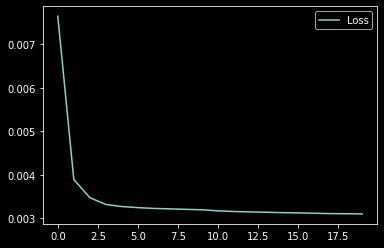

In [48]:
plt.plot(history_fusion.history["loss"], label="Loss")
plt.legend()
plt.show()

In [49]:
three_test_ds = ori_test_ds.map(preprocess_three).batch(1)

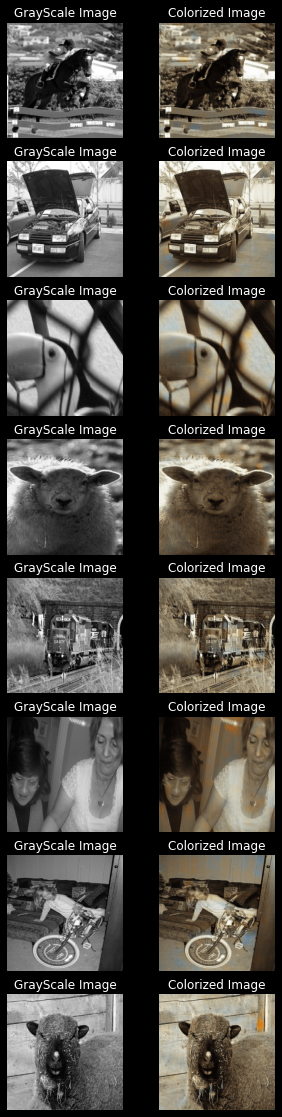

In [50]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 20))
[ax.axis("off") for ax in np.ravel(axes)]


for ((inputs, ori_color), (ax_bw, ax_orig)) in zip(three_train_ds.take(8), axes):
    ax_bw.imshow(inputs["ori_gray"][0,...,0], cmap="gray")
    ax_bw.set_title("GrayScale Image")
    
    pred = fusion_model.predict([inputs["ori_gray"], inputs["crop_gray"], inputs["box"]])
    ax_orig.imshow(pred[0])
    ax_orig.set_title("Colorized Image")